In [ ]:
!pip install tensorflow==2.11.1

<ipython-input-13-8834d12525e3>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
<ipython-input-13-8834d12525e3>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Epoch 1/50
 1/79 [..............................] - ETA: 7s - loss: 0.2511

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79/79 [==============================] - 7s 87ms/step - loss: 0.0363 - val_loss: 0.0223
Epoch 2/50
79/79 [==============================] - 5s 63ms/step - loss: 0.0209 - val_loss: 0.0165
Epoch 3/50
79/79 [==============================] - 5s 69ms/step - loss: 0.0176 - val_loss: 0.0117
Epoch 4/50
79/79 [==============================] - 7s 83ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 5/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0140 - val_loss: 0.0119
Epoch 6/50
79/79 [==============================] - 7s 83ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 7/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0117 - val_loss: 0.0089
Epoch 8/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0120 - val_loss: 0.0075
Epoch 9/50
79/79 [==============================] - 7s 83ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 10/50
79/79 [==============================] - 5s 67ms/step - loss: 0.0101 - val_loss: 0.0068
Epoch 11/50
79/79 [=

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


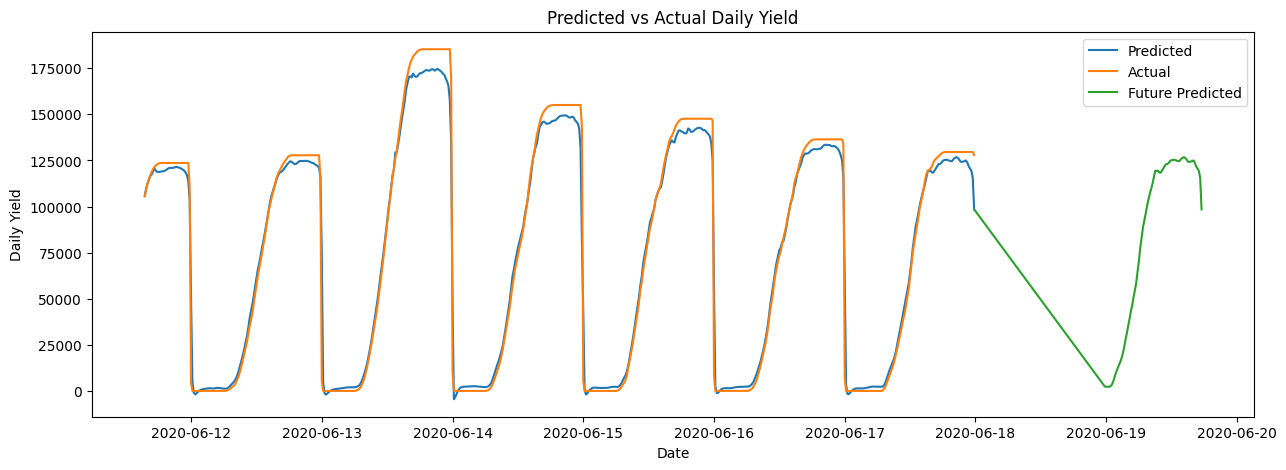

In [13]:
# Final next day forecasting
 
import requests
import json
import csv
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam


# --- firebase.py ---
generation_url = "https://esp-firebase-demo-103cc-default-rtdb.asia-southeast1.firebasedatabase.app/.json"
weather_url = "https://weather-1609-default-rtdb.asia-southeast1.firebasedatabase.app/.json"

max_retries = 5
retry_delay = 1

def download_data(url):
    for retry_count in range(max_retries):
        try:
            response = requests.get(url, timeout=20)
            break
        except requests.exceptions.RequestException:
            print(f"Connection failed, retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
    else:
        print("Failed to establish a connection to the Firebase Realtime Database.")
        exit()

    return json.loads(response.content)

generation_data = download_data(generation_url)
weather_data = download_data(weather_url)

with open("generation_data.csv", "w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["DATE_TIME", "PLANT_ID", "SOURCE_KEY", "DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"])
    for value in generation_data:
        writer.writerow([value["DATE_TIME"], value["PLANT_ID"], value["SOURCE_KEY"], value["DC_POWER"], value["AC_POWER"], value["DAILY_YIELD"], value["TOTAL_YIELD"]])

with open("weather_data.csv", "w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["DATE_TIME", "PLANT_ID", "SOURCE_KEY", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"])
    for value in weather_data:
        writer.writerow([value["DATE_TIME"], value["PLANT_ID"], value["SOURCE_KEY"], value["AMBIENT_TEMPERATURE"], value["MODULE_TEMPERATURE"], value["IRRADIATION"]])

# --- preprocessing.py ---
gen_1 = pd.read_csv('./generation_data.csv')
gen_1.drop(columns=['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)
sens_1 = pd.read_csv('./weather_data.csv')
sens_1.drop(columns=['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)

gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])
sens_1['DATE_TIME'] = pd.to_datetime(sens_1['DATE_TIME'])

df_gen = gen_1.groupby('DATE_TIME').sum().reset_index()
df_gen['time'] = df_gen['DATE_TIME'].dt.time

final_df = pd.merge(df_gen, sens_1, how='outer', on='DATE_TIME')
final_df.to_csv('./final_data.csv')

gen_1 = pd.read_csv('./generation_data.csv')
gen_1.drop(columns=['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)
sens_1 = pd.read_csv('./weather_data.csv')
sens_1.drop(columns=['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)

gen_1['DATE_TIME'] = pd.to_datetime(gen_1['DATE_TIME'])
sens_1['DATE_TIME'] = pd.to_datetime(sens_1['DATE_TIME'])

df_gen = gen_1.groupby('DATE_TIME').sum().reset_index()
df_gen['time'] = df_gen['DATE_TIME'].dt.time

final_df = pd.merge(df_gen, sens_1, how='outer', on='DATE_TIME')
final_df.to_csv('./final_data.csv')


# --- training_eval.py ---
def preprocess_data(df):
    df = df[['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']]
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
    df.set_index('DATE_TIME', inplace=True)
    df.dropna(inplace=True)
    return df

def split_and_normalize_data(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    train_data = df[:train_size].values
    test_data = df[train_size:].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, scaler


def create_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

def build_and_train_lstm_model(train_X, train_y, test_X, test_y, window_size, learning_rate=0.001, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(window_size, train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, run_eagerly=True)


    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1)

    return model, history


def plot_predicted_vs_actual(test_X, test_y, test_pred, df, train_size, window_size, scaler, future_df=None):
    test_pred = scaler.inverse_transform(np.concatenate((test_X[:, -1, :-1], test_pred), axis=1))[:, -1]
    test_y = scaler.inverse_transform(np.concatenate((test_X[:, -1, :-1], test_y.reshape(-1, 1)), axis=1))[:, -1]

    test_df = pd.DataFrame({'DATE_TIME': df.index[train_size + window_size:], 'Predicted': test_pred, 'Actual': test_y})
    test_df.set_index('DATE_TIME', inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(test_df.index, test_df['Predicted'], label='Predicted')
    plt.plot(test_df.index, test_df['Actual'], label='Actual')
    if future_df is not None:
        plt.plot(future_df.index, future_df['Predicted'], label='Future Predicted')
    plt.title('Predicted vs Actual Daily Yield')
    plt.xlabel('Date')
    plt.ylabel('Daily Yield')
    plt.legend()
    plt.show()

def train_and_evaluate():
    # Preprocess data
    df = pd.read_csv('final_data.csv')
    df = preprocess_data(df)

    # Split and normalize data
    train_data, test_data, scaler = split_and_normalize_data(df)

    # Create windowed dataset
    window_size = 24
    train_X, train_y = create_dataset(train_data, window_size)
    test_X, test_y = create_dataset(test_data, window_size)

    # Build and train LSTM model
    model, history = build_and_train_lstm_model(train_X, train_y, test_X, test_y, window_size)

    # Make predictions on test data
    test_pred = model.predict(test_X)

    # Create test_df DataFrame
    train_size = int(len(df) * 0.8)
    test_pred_transformed = scaler.inverse_transform(np.concatenate((test_X[:, -1, :-1], test_pred), axis=1))[:, -1]
    test_y_transformed = scaler.inverse_transform(np.concatenate((test_X[:, -1, :-1], test_y.reshape(-1, 1)), axis=1))[:, -1]
    test_df = pd.DataFrame({'DATE_TIME': df.index[train_size + window_size:], 'Predicted': test_pred_transformed, 'Actual': test_y_transformed})
    test_df.set_index('DATE_TIME', inplace=True)

    # Get the last 24 hours of the test data
    last_24_hours = df[-96:]

    # Normalize the last 24 hours of the test data
    last_24_hours = scaler.transform(last_24_hours)

    # Create a windowed dataset with a window size of 24
    future_X, _ = create_dataset(last_24_hours, window_size)

    # Make predictions on the future dataset
    future_pred = model.predict(future_X)

    # Inverse transform the predictions to get the original values
    future_pred = scaler.inverse_transform(np.concatenate((future_X[:, -1, :-1], future_pred), axis=1))[:, -1]

    # Create a datetime range for the next day with the same frequency as the data
    date_range = pd.date_range(start=df.index[-1], periods=96, freq='15min')

    # Create a new date range with a smaller number of periods
    future_range = pd.date_range(start=date_range[-1], periods=len(future_pred)+1, freq='15min')[1:]

    # Create a dataframe with the predicted values and the datetime range
    future_df = pd.DataFrame({'DATE_TIME': future_range, 'Predicted': future_pred})
    future_power_generation = future_df['Predicted'].sum()
    
    # Set DATE_TIME as index
    future_df.set_index('DATE_TIME', inplace=True)

    # Concatenate the two dataframes
    future_df_fin = pd.concat([test_df.tail(1), future_df], axis=0)
    another_df = pd.concat ([test_df, future_df], axis=0)
    
    # Plot the results
    plot_predicted_vs_actual(test_X, test_y, test_pred, df, train_size, window_size, scaler, future_df=future_df_fin)

    # Add a new column 'col3' with None values (or any other desired default value)
    another_df['Forecast'] = np.NaN

    # Set the zero index value of the new column to the single value variable
    another_df.loc[0, 'Forecast'] = future_power_generation
    another_df.to_csv('predictions.csv')

    future_df_fin.to_csv('future_predictions.csv')

    return test_df, test_pred, future_df_fin

test_df, test_pred, future_df = train_and_evaluate()

### **Classical Time Series Forecasting using LSTM**

In [7]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import seaborn as sns

In [18]:
# Load data
df = pd.read_csv('/content/final_data.csv')

# Data Manipulation and Information
new_columns = ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'time', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD', "TOTAL_YIELD"]
df_new = df.reindex(new_columns, axis=1)
df_new.dropna(inplace=True)
df_new.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3183 non-null   int64  
 1   DATE_TIME            3183 non-null   object 
 2   DC_POWER             3158 non-null   float64
 3   AC_POWER             3158 non-null   float64
 4   DAILY_YIELD          3158 non-null   float64
 5   TOTAL_YIELD          3158 non-null   float64
 6   time                 3158 non-null   object 
 7   AMBIENT_TEMPERATURE  3182 non-null   float64
 8   MODULE_TEMPERATURE   3182 non-null   float64
 9   IRRADIATION          3182 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 248.8+ KB


<ipython-input-19-a70dce9e6c88>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mp = sns.heatmap(df_new.corr(), cmap="YlGnBu", annot=True)


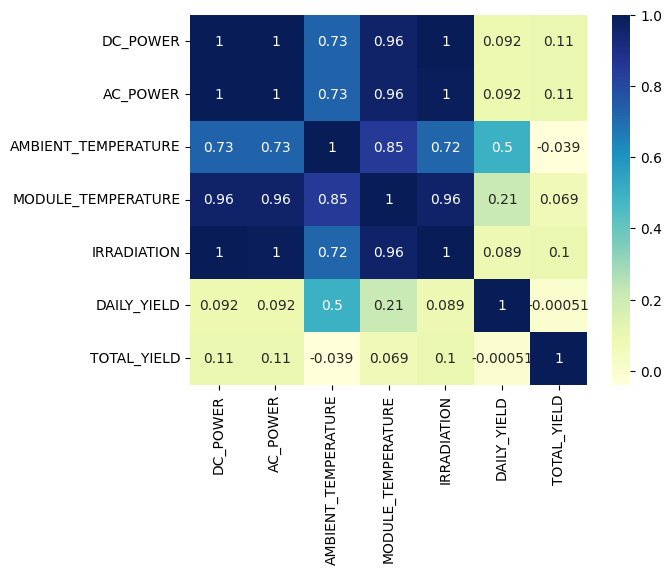

In [19]:
import seaborn as sns
mp = sns.heatmap(df_new.corr(), cmap="YlGnBu", annot=True)

In [ ]:
#@title Hidden cell
# Convert timestamp column to datetime format
#df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp column as index
#df.set_index('timestamp', inplace=True)

# Select relevant features
features = ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']
df = df_new[features]

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size].values
test_data = df[train_size:].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Define window size for time series data
window_size = [15, 20, 25, 30, 35, 40, 45, 50]
test_loss = []

# Function to create windowed dataset
def create_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i,-1])
    return np.array(X), np.array(y)

for i, val in enumerate(window_size):

  # Create windowed training and testing datasets
  train_X, train_y = create_dataset(train_data, window_size[i])
  test_X, test_y = create_dataset(test_data, window_size[i])

  # Define LSTM model
  model = Sequential()
  model.add(LSTM(units=50, input_shape=(window_size[i], train_X.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))

  # Compile model
  optimizer = Adam(lr=0.001)
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  # Train model
  history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=1)

  # Evaluate model on test data
  test_loss.append(model.evaluate(test_X, test_y, verbose=0)
  
  print('Test loss: {:.4f}'.format(test_loss[i]))

  # Make predictions on test data
  test_pred = model.predict(test_X)

  # Inverse transform data to get original values
  test_pred = scaler.inverse_transform(np.concatenate((test_X[:,-1,:-1], test_pred), axis=1))[:,-1]
  test_y = scaler.inverse_transform(np.concatenate((test_X[:,-1,:-1], test_y.reshape(-1,1)), axis=1))[:,-1]

  # Plot predicted vs actual values
  import matplotlib.pyplot as plt
  plt.plot(test_y, label='Actual')
  plt.plot(test_pred, label='Predicted')
  plt.legend()
  plt.show()

<ipython-input-20-48ee91008d68>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])


Epoch 1/100
 2/79 [..............................] - ETA: 4s - loss: 0.1671

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


79/79 [==============================] - 5s 64ms/step - loss: 0.0332 - val_loss: 0.0176
Epoch 2/100
79/79 [==============================] - 5s 66ms/step - loss: 0.0195 - val_loss: 0.0174
Epoch 3/100
79/79 [==============================] - 7s 83ms/step - loss: 0.0174 - val_loss: 0.0104
Epoch 4/100
79/79 [==============================] - 5s 64ms/step - loss: 0.0139 - val_loss: 0.0112
Epoch 5/100
79/79 [==============================] - 6s 77ms/step - loss: 0.0134 - val_loss: 0.0086
Epoch 6/100
79/79 [==============================] - 5s 66ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 7/100
79/79 [==============================] - 5s 63ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 8/100
79/79 [==============================] - 6s 82ms/step - loss: 0.0111 - val_loss: 0.0063
Epoch 9/100
79/79 [==============================] - 5s 67ms/step - loss: 0.0103 - val_loss: 0.0064
Epoch 10/100
79/79 [==============================] - 6s 72ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 11/10

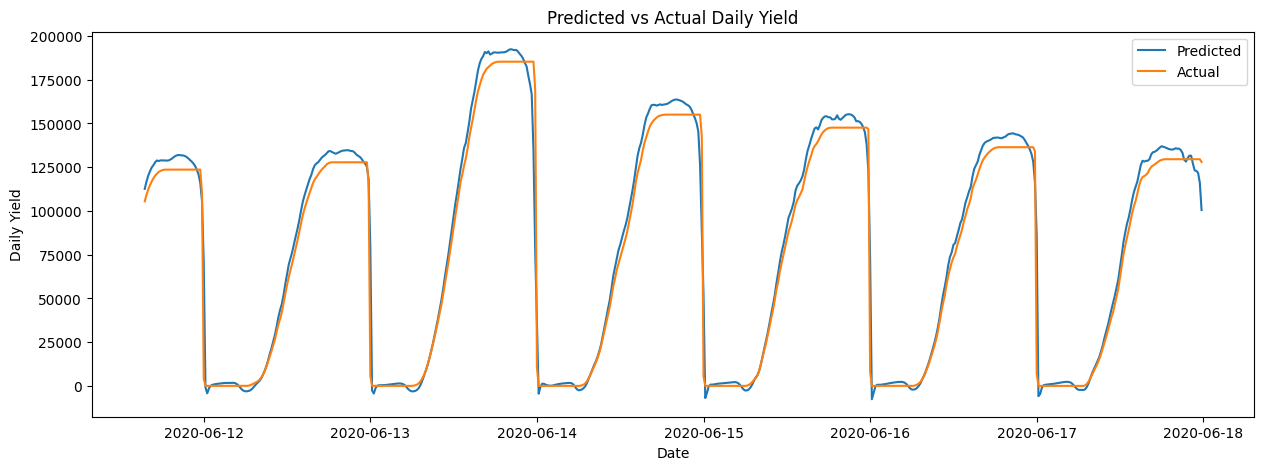

In [20]:
df_new = df_new[['DATE_TIME','DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD', 'TOTAL_YIELD']]
df_new
# Select relevant features
features = ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']
df = df_new[features]

# Convert timestamp column to datetime format
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

# Set timestamp column as index
df.set_index('DATE_TIME', inplace=True)

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size].values
test_data = df[train_size:].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Define window size for time series data
window_size = 24

# Function to create windowed dataset
def create_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i,-1])
    return np.array(X), np.array(y)


# Create windowed training and testing datasets
train_X, train_y = create_dataset(train_data, window_size)
test_X, test_y = create_dataset(test_data, window_size)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(window_size, train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train model
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=1)

# Evaluate model on test data
test_loss = model.evaluate(test_X, test_y, verbose=0)

print('Test loss: {:.4f}'.format(test_loss))

# Make predictions on test data
test_pred = model.predict(test_X) 

# Inverse transform data to get original values
test_pred = scaler.inverse_transform(np.concatenate((test_X[:,-1,:-1], test_pred), axis=1))[:,-1]
test_y = scaler.inverse_transform(np.concatenate((test_X[:,-1,:-1], test_y.reshape(-1,1)), axis=1))[:,-1]

# Plot predicted vs actual values

# Create new dataframe with DATE_TIME and predicted/actual values
test_df = pd.DataFrame({'DATE_TIME': df.index[train_size+window_size:], 'Predicted': test_pred, 'Actual': test_y})

# Set DATE_TIME as index
test_df.set_index('DATE_TIME', inplace=True)

# Plot predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(test_df.index, test_df['Predicted'], label='Predicted')
plt.plot(test_df.index, test_df['Actual'], label='Actual')
plt.title('Predicted vs Actual Daily Yield')
plt.xlabel('Date')
plt.ylabel('Daily Yield')
plt.legend()
plt.show()

3/3 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_

3/3 [==============================] - 0s 16ms/step


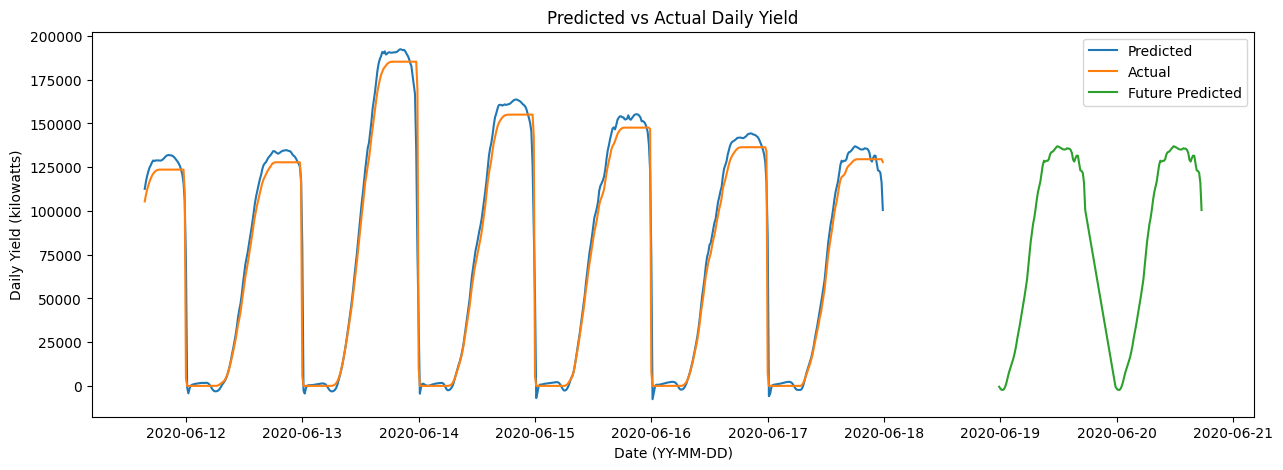

In [22]:
# Get the last 24 hours of the test data
last_24_hours = df[-96:]

# Normalize the last 24 hours of the test data
last_24_hours = scaler.transform(last_24_hours)

# Create a windowed dataset with a window size of 24
future_X, _ = create_dataset(last_24_hours, window_size)

# Make predictions on the future dataset
future_pred = model.predict(future_X)

# Inverse transform the predictions to get the original values
future_pred = scaler.inverse_transform(np.concatenate((future_X[:,-1,:-1], future_pred), axis=1))[:,-1]

# Create a datetime range for the next day with the same frequency as the data
date_range = pd.date_range(start=df.index[-1], periods=96, freq='15min')

# Create a new date range with a smaller number of periods
future_range = pd.date_range(start=date_range[-1], periods=len(future_pred)+1, freq='15min')[1:]

# Create a dataframe with the predicted values and the datetime range
future_df = pd.DataFrame({'DATE_TIME': future_range, 'Predicted': future_pred})

# Set DATE_TIME as index
future_df.set_index('DATE_TIME', inplace=True)

# Get the last 24 hours of the test data
last_24_hours = df[-96:]

# Normalize the last 24 hours of the test data
last_24_hours = scaler.transform(last_24_hours)

# Create a windowed dataset with a window size of 24
future_X, _ = create_dataset(last_24_hours, window_size)

# Make predictions on the future dataset
future_pred = model.predict(future_X)

# Inverse transform the predictions to get the original values
future_pred = scaler.inverse_transform(np.concatenate((future_X[:,-1,:-1], future_pred), axis=1))[:,-1]

# Create a datetime range for the next 2 days with the same frequency as the data
date_range = pd.date_range(start=df.index[-1], periods=192, freq='15min')

# Create a new date range with a smaller number of periods
future_range = pd.date_range(start=date_range[-48], periods=len(future_pred)+48, freq='15min')[48:]

# Create a dataframe with the predicted values and the datetime range
future_df2 = pd.DataFrame({'DATE_TIME': future_range, 'Predicted': future_pred})

# Set DATE_TIME as index
future_df2.set_index('DATE_TIME', inplace=True)

# Concatenate the two dataframes
future_df_fin = pd.concat([future_df, future_df2], axis=0)

# Plot the results
plt.figure(figsize=(15,5))
plt.plot(test_df.index, test_df['Predicted'], label='Predicted')
plt.plot(test_df.index, test_df['Actual'], label='Actual')
plt.plot(future_df_fin.index, future_df_fin['Predicted'], label='Future Predicted')
plt.title('Predicted vs Actual Daily Yield')
plt.xlabel('Date (YY-MM-DD)')
plt.ylabel('Daily Yield (kilowatts)')
plt.legend()
plt.show()

### **Quantum LSTM**


In [ ]:
import torch
import torch.nn as nn
import pennylane as qml

class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [ ]:
import pennylane as qml
import numpy as np
import pandas as pd

# Constants
NUM_WIRES = 3  # number of qubits
NUM_LAYERS = 3  # number of layers in the quantum circuit
NUM_SHOTS = 1000  # number of circuit evaluations for each set of parameters

# Load data
df = pd.read_csv('solar_power_data.csv')

# Preprocess data
data = df[['solar_irradiance', 'ambient_temp', 'humidity', 'power_generated']].values
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)  # standardize data

# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(split_ratio * len(data))

train_data = data[:split_idx]
test_data = data[split_idx:]

# Define quantum circuit
def circuit(params, x):
    for i in range(NUM_WIRES):
        qml.RX(x[i], wires=i)

    for layer_idx in range(NUM_LAYERS):
        for i in range(NUM_WIRES):
            qml.RZ(params[layer_idx, i], wires=i)

        for i in range(NUM_WIRES):
            qml.CNOT(wires=[i, (i+1)%NUM_WIRES])

    return qml.expval(qml.PauliZ(0))

# Define cost function and optimizer
def cost(params, x):
    pred = circuit(params, x[:-1])
    return (pred - x[-1])**2

opt = qml.GradientDescentOptimizer(0.1)

# Train circuit
params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(NUM_LAYERS, NUM_WIRES))

for i in range(100):
    np.random.shuffle(train_data)
    batches = [train_data[k:k+10] for k in range(0, len(train_data), 10)]
    for batch in batches:
        gradients = []
        for x in batch:
            gradient_fn = qml.grad(cost, argnum=0)
            gradient = gradient_fn(params, x)
            gradients.append(gradient)
        avg_gradient = np.mean(gradients, axis=0)
        params = opt.step(avg_gradient, params)

    if (i+1) % 10 == 0:
        print(f'Iteration {i+1}, Cost = {cost(params, test_data[0])}')

# Evaluate circuit
mse = 0
for x in test_data:
    pred = circuit(params, x[:-1])
    mse += (pred - x[-1])**2
mse /= len(test_data)

print(f'Test MSE = {mse:.3f}')
